In [1]:
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
%matplotlib nbagg
from astropy.table import Column

Neural networks not available in this version of scikit-learn. Neural networks are available from development version 0.18.


## SN numbers with classification code
SN001695   - 2

2457 - 33

2542 - 1

5399 - 2

13481 - 2

13866 - 1 

16742 - 21

17270 - 32

27266 -32

64968 - 23

149147 -21

In [2]:
dataset='spcc'

In [3]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

In [4]:
#Data root
rt=os.path.join('SPCC_SUBSET','')

In [5]:
dat=sndata.Dataset(rt)

Reading data...
3 objects read into memory.


In [6]:
read_from_file=False #True #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'%s_all' %dataset)

In [7]:
dat.object_names[0]
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

In [8]:
#test_table = dat.data['DES_SN001695.DAT'] #get_lightcurve

#dat.plot_all()
#dat.data[dat.object_names[0]]

In [9]:
type_II = []
for i in range(len(dat.data['DES_SN002457.DAT']['flux'])):
    type_II.append(np.random.normal(dat.data['DES_SN002457.DAT']['flux'][i], dat.data['DES_SN002457.DAT']['flux_error'][i], 5))

In [10]:
type_Ia = []
for i in range(len(dat.data['DES_SN002542.DAT']['flux'])):
    type_Ia.append(np.random.normal(dat.data['DES_SN002542.DAT']['flux'][i], dat.data['DES_SN002542.DAT']['flux_error'][i], 5))

In [11]:
type_Ibc = []
for i in range(len(dat.data['DES_SN005399.DAT']['flux'])):
    type_Ibc.append(np.random.normal(dat.data['DES_SN005399.DAT']['flux'][i], dat.data['DES_SN005399.DAT']['flux_error'][i], 5))

In [12]:
type_Ia = np.array(type_Ia)
type_Ibc = np.array(type_Ibc)
type_II = np.array(type_II)

In [16]:
#test_table.replace_column('flux', type_II[:,0])

In [17]:
#test_table.write('testing.dat',format = 'ascii')

In [18]:
#dat.data['DES_SN001695.DAT']
#print type_Ia

In [14]:
#isinstance(dat.object_names, np.ndarray)

In [110]:
#test_table_II = dat.data['DES_SN002457.DAT']

In [13]:
#dir(dat)

In [15]:
#print data[0:10]
#print data[5].split()
def make_new_data(filename, table, output):
    with open(filename) as f:
        data = f.read().split("\n")
    filters = data[5].split()
    survey = data[0].split()
    stuffRA = data[6].split()
    stuffDec = data[7].split()
    MWEBV = data[11].split()
    table.meta = {survey[0][:-1]: survey[1], stuffRA[0][:-1]: stuffRA[1], stuffDec[0][:-1]: stuffDec[1],filters[0][:-1]: filters[1],
                 MWEBV[0][:-1]: MWEBV[1]}
    #table.rename_column('mjd', 'MJD')
    #table.rename_column('filter ', 'FLT')
    #table.rename_column('flux', 'FLUXCAL')
    #table.rename_column('flux_error', 'FLUXCALERR')
    sncosmo.write_lc(table, 'new_mocks/%s.dat'%output,pedantic=True, format = 'snana')

In [16]:
filename_II = 'SPCC_SUBSET/DES_SN002457.DAT'
filename_Ia = 'SPCC_SUBSET/DES_SN002542.DAT'
filename_Ibc = 'SPCC_SUBSET/DES_SN005399.DAT'

test_table_II = dat.data['DES_SN002457.DAT']
test_table_Ia = dat.data['DES_SN002542.DAT']
test_table_Ibc = dat.data['DES_SN005399.DAT']
#print test_table_II

test_table_II.rename_column('flux', 'FLUXCAL')
test_table_II.rename_column('flux_error', 'FLUXCALERR')
    
test_table_Ibc.rename_column('flux', 'FLUXCAL')
test_table_Ibc.rename_column('flux_error', 'FLUXCALERR')
    
test_table_Ia.rename_column('flux', 'FLUXCAL')
test_table_Ia.rename_column('flux_error', 'FLUXCALERR')

objs=[]
new_data={}

for i in range(5):
    
    
    test_table_Ia.replace_column('FLUXCAL', type_Ia[:,i])

     
    test_table_Ibc.replace_column('FLUXCAL', type_Ibc[:,i])
 
    test_table_II.replace_column('FLUXCAL', type_II[:,i])
    
    make_new_data(filename_Ibc, test_table_Ibc, 'Ibc_%s'%i)
    make_new_data(filename_II, test_table_II, 'II_%s'%i)
    make_new_data(filename_Ia, test_table_Ia, 'Ia_%s'%i)
    
    #objs.append((str)(i))
    new_data[(str)(i)]=test_table_II.copy()  #new_light_curve_Ia
    new_data[(str)(i+5)]=test_table_Ia.copy()#new_light_curve_II
    new_data[(str)(i+10)]=test_table_Ibc.copy()#new_light_curve_Ibc
    
sncosmo.read_lc(new_data)
#new_data = Counter(new_data_Ia) + Counter(new_data_II) + Counter(new_data_Ibc)

for i in range(15):    
    objs.append((str)(i))
    
dat.object_names=np.asarray(objs)
dat.data=new_data

      mjd       filter   flux  flux_error  zp  zpsys
--------------- ------ ------- ---------- ---- -----
            0.0   desg  -1.628      10.48 27.5    ab
0.0160000000033   desr  -12.65      7.845 27.5    ab
0.0320000000065   desi  -10.86      9.314 27.5    ab
 0.977000000006   desz  -4.156      5.328 27.5    ab
          1.985   desg  -2.024      3.205 27.5    ab
            2.0   desr  0.0281      2.425 27.5    ab
          2.016   desi  0.3376       4.31 27.5    ab
          9.957   desz  -6.591      27.32 27.5    ab
         10.106   desg   3.678      25.57 27.5    ab
         10.121   desr  -1.047      4.152 27.5    ab
            ...    ...     ...        ...  ...   ...
        113.868   desr   1.241      4.828 27.5    ab
        113.957   desi   14.87       5.61 27.5    ab
        113.965   desz   13.31      5.166 27.5    ab
        125.817   desg -0.2672       2.48 27.5    ab
        125.821   desr   2.634      1.659 27.5    ab
        125.836   desi   5.357      2.513 27.5

In [113]:
filename = 'SPCC_SUBSET/DES_SN002457.DAT'
with open(filename) as f:
    data = f.read().split("\n")

In [144]:
#for i in range(0,len(data)):
#    print i, np.where(data[i].split()[0]=="FLUXCALERR:")
# MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR  SIM_MAG
test_table_II.rename_column( 'MJD','mjd')

In [146]:
type(test_table_II)
print test_table_II
make_new_data(filename , test_table_II)

      mjd       filter       flux      flux_error  zp  zpsys
--------------- ------ --------------- ---------- ---- -----
            0.0   desg   -14.720074909      10.48 27.5    ab
0.0160000000033   desr  -10.0200738069      7.845 27.5    ab
0.0320000000065   desi   15.8283821719      9.314 27.5    ab
 0.977000000006   desz  -1.54473523767      5.328 27.5    ab
          1.985   desg  -2.07808996718      3.205 27.5    ab
            2.0   desr  -2.68677401212      2.425 27.5    ab
          2.016   desi   -3.0445893869       4.31 27.5    ab
          9.957   desz   14.1105912517      27.32 27.5    ab
         10.106   desg  -17.7926700123      25.57 27.5    ab
         10.121   desr   3.18628290331      4.152 27.5    ab
            ...    ...             ...        ...  ...   ...
        113.868   desr  -2.87035155679      4.828 27.5    ab
        113.957   desi    12.558242454       5.61 27.5    ab
        113.965   desz   11.8116159538      5.166 27.5    ab
        125.817   desg  

In [25]:
sncosmo.write_lc(test_table_II, 
                'test_table', format='snana')

ValueError: Missing required metadata kw: RA

In [18]:
#For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3)
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

<IPython.core.display.Javascript object>


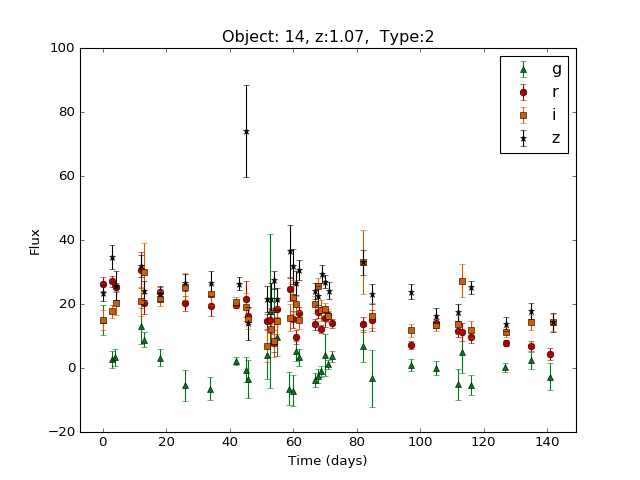

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,5.12773482611,10.48,27.5,ab
0.0160000000033,desr,-25.547566965,7.845,27.5,ab
0.0320000000065,desi,2.53942086865,9.314,27.5,ab
0.977000000006,desz,-3.55379552505,5.328,27.5,ab
1.985,desg,3.68469587618,3.205,27.5,ab
2.0,desr,1.35975185827,2.425,27.5,ab
2.016,desi,-2.72036673211,4.31,27.5,ab
9.957,desz,-25.5723808372,27.32,27.5,ab
10.106,desg,21.6569924755,25.57,27.5,ab


In [19]:
dat.plot_all()
dat.data[dat.object_names[0]]

In [36]:
dat.get_object_names()

array(['DES_SN002457.DAT', 'DES_SN002542.DAT', 'DES_SN005399.DAT'], 
      dtype='|S16')

In [26]:
mod1Feats=snfeatures.ParametricFeatures('karpenka',sampler='leastsq')

In [28]:
%%capture --no-stdout
if read_from_file:
    mod1_features=Table.read('%s_karpenka.dat' %run_name, format='ascii')
    blah=mod1_features['Object'].astype(str)
    mod1_features.replace_column('Object', blah)
else:
    mod1_features=mod1Feats.extract_features(dat,nprocesses=6,chain_directory=out_int)
    mod1_features.write('%s_karpenka.dat' %run_name, format='ascii')

15 objects fitted
Time taken is 3.59 seconds


In [34]:
#Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.
for c in mod1_features.colnames[1:]:
    mod1_features[c][np.isnan(mod1_features[c])]=0
    
print mod1_features

Object desg-logA desg-logB desg-t0 ...   desz-t1   desz-T_rise desz-T_fall
------ --------- --------- ------- ... ----------- ----------- -----------
     0   2.38137  -3.48903 68.8674 ...  2.4919e-05     2.46609     19.1614
     1  -8.02858     4.241 69.3023 ...     99.9999  0.00459644     74.9492
     2 -0.168365  -1.15062 24.2094 ...     99.9978     2.96625      49.885
     3   -8.8668   4.52717 65.5084 ... 0.000345783 0.000976516     16.6522
     4   -1.1022   2.43362 29.9359 ...     99.9999     3.07166     53.7644
     5  -5.46524   2.02873 6.08712 ...     25.7114     4.90766      17.466
     6  -4.76349   1.07703 4.08325 ...     20.4173      5.6665      22.665
     7  -5.84966   2.63388 7.02519 ...     28.8766      5.0137     31.5863
     8  -1.15329  -2.13015 4.76573 ...      24.598     4.91229     17.6525
     9  -5.20489   2.19687 9.05858 ...     32.6036     5.66045     34.2314
    10   0.41203  -1.73109 1.57516 ...     6.29117  0.00915248     37.6758
    11 -0.462417  -2.6471

In [39]:
mod1Feats.fit_sn
#dat.set_model(mod1Feats.fit_sn,mod1_features)

<bound method ParametricFeatures.fit_sn of <snmachine.snfeatures.ParametricFeatures instance at 0x110a6def0>>

In [17]:
#np.sort(dat.object_names)

In [23]:
#dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

Fitting supernova models...
Models fitted.


In [9]:
#dat.plot_all()

In [10]:
#wave_features

In [11]:
#types

In [12]:
#join(wave_features, types)

In [13]:
#plt.figure()
#tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

In [14]:
#This code takes the fitted parameters and generates the model light curve for plotting purposes.
#dat.set_model(salt2Feats.fit_sn,salt2_features)

In [15]:
#dat.plot_all()

In [16]:
#dat.data[dat.object_names[5]]